In [88]:
# === 1. Setup ===
from py2neo import Graph
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import lightgbm as lgb
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [89]:
# === 2. Connect to Neo4j ===
graph = Graph("bolt://localhost:7687", auth=("neo4j", "12341234")) #Replace according to your username and password

In [90]:
# === 3. Fetch Papers and REFERS_TO relationships ===
query_papers = """
MATCH (p:Paper)
RETURN p.ID AS id
LIMIT 10000
"""
papers_df = graph.run(query_papers).to_data_frame()


paper_ids = papers_df['id'].tolist()

edges_df = graph.run(
    """
    MATCH (p1:Paper)-[:REFERS_TO]->(p2:Paper)
    WHERE p1.ID IN $paper_ids AND p2.ID IN $paper_ids AND p1.ID <> p2.ID
    RETURN p1.ID AS source, p2.ID AS target
    """, paper_ids=paper_ids
).to_data_frame()

In [91]:
papers_df.describe()

,id
count,10000
unique,10000
top,35c0875eac2eab86a19b145ae971d983222f0117
freq,1


In [92]:
# === 4. Create NetworkX Graph ===
G = nx.DiGraph()
G.add_nodes_from(papers_df['id'])
G.add_edges_from(edges_df[['source', 'target']].values)

In [93]:
# === 5. Create Positive and Negative Samples ===
positive_edges = list(G.edges())

def sample_negative_edges(G, num_samples, seed=42):
    random.seed(seed)
    nodes = list(G.nodes())
    negatives = set()
    while len(negatives) < num_samples:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negatives:
            negatives.add((u, v))
    return list(negatives)

negative_edges = sample_negative_edges(G, len(positive_edges))

# Combine into dataframe
edge_data = []
for u, v in positive_edges:
    edge_data.append((u, v, 1))
for u, v in negative_edges:
    edge_data.append((u, v, 0))

edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'label'])

In [94]:
# === 6. Feature Engineering ===
G_undirected = G.to_undirected()
cn_cache, aa_cache = {}, {}

for u, v in edge_df[['source', 'target']].values:
    try:
        cn = len(list(nx.common_neighbors(G_undirected, u, v)))
        aa = sum(1 / np.log(G_undirected.degree(w)) for w in nx.common_neighbors(G_undirected, u, v))
    except:
        cn, aa = 0, 0
    cn_cache[(u, v)] = cn
    aa_cache[(u, v)] = aa

In [95]:
# === 7. Feature Extraction ===
features = []
for i, row in edge_df.iterrows():
    u, v = row['source'], row['target']
    cn = cn_cache.get((u, v), 0)
    aa = aa_cache.get((u, v), 0)
    features.append([cn, aa, row['label']])

features_df = pd.DataFrame(features, columns=['common_neighbors', 'adamic_adar', 'label'])

In [96]:
# === 8. Train Test Split ===
X = features_df.drop('label', axis=1)
y = features_df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [97]:
# === 9. Train LightGBM Model ===
clf = lgb.LGBMClassifier(device='gpu', gpu_platform_id=0, gpu_device_id=0)
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7611, number of negative: 7580
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 15191, number of used features: 2
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Ellesmere, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501020 -> initscore=0.004081
[LightGBM] [Info] Start training from score 0.004081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(device='gpu', gpu_device_id=0, gpu_platform_id=0)

In [98]:
# === 10. Evaluation ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC AUC: 0.5312136961173953
Precision: 0.9722222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68      3271
           1       0.97      0.06      0.12      3240

    accuracy                           0.53      6511
   macro avg       0.75      0.53      0.40      6511
weighted avg       0.74      0.53      0.40      6511



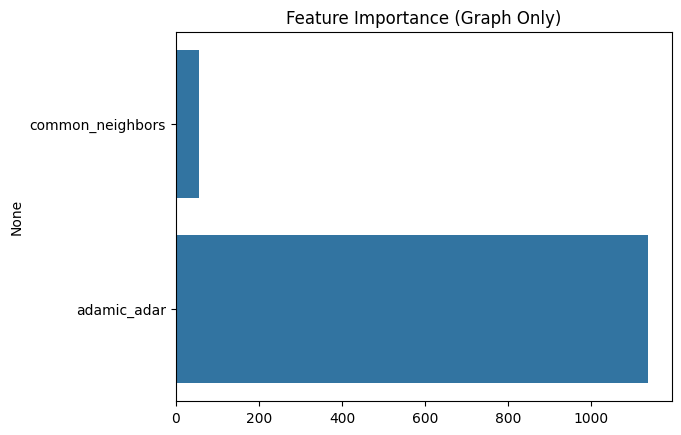

In [99]:
# === 11. Feature Importance ===
importance = clf.feature_importances_
feat_names = X.columns
sns.barplot(x=importance, y=feat_names)
plt.title("Feature Importance (Graph Only)")
plt.show()